---
title: "Feature Selection"
format: 
  html:
    embed-resources: true
---

In this notebook, we apply two feature selection techniques — Lasso regularization and Best Subset Selection — to identify the most relevant predictors of chronic absenteeism in U.S. school districts. The final dataset will be saved for model training and evaluation.

### Load Libraries and Data

We remove identifier variables and outcome-related features to avoid data leakage. Finally, we remove the target columns themselves so we can focus on the features. 

In [1]:
# Load necessary libraries
library(tidyverse) |> suppressPackageStartupMessages() |> suppressWarnings()
library(glmnet) |> suppressPackageStartupMessages() |> suppressWarnings()
library(leaps) |> suppressPackageStartupMessages() |> suppressWarnings()
library(caret) |> suppressPackageStartupMessages() |> suppressWarnings()

# Load cleaned dataset
df <- read.csv("../data/clean/cleaned_school_data.csv")

# define certain groups of columns
identifier_cols <- c("state_name", "leaid", "lea_name")

target_cols <- c("high_absenteeism",
                 "high_absenteeism_doe",
                 "absenteeism_class")

target_related_cols <- c("num_chronically_absent_students",
                         "chronic_absentee_ratio")

# subset data
df_features <- df |>
  # Drop identifier columns
  select(-all_of(identifier_cols)) |>
  # Drop target related columns
  select(-all_of(target_related_cols)) |>
  # Drop target columns
  select(-all_of(target_cols))

# View structure of the preprocessed dataset
head(df_features)


,total_students,am_indian_female,am_indian_male,am_indian_total,asian_female,asian_male,asian_total,black_female,black_male,black_total,⋯,white_pct,native_hawaiian_pacific_islander_pct,student_poverty_ratio,total_federal_revenue,total_state_revenue,total_local_revenue,total_expenditures,total_salaries,total_employee_benefits,expenditures_per_student
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,5767,4,2,6,2,1,3,24,24,48,⋯,0.3563,0.0003,0.21595855,13132000,42566000,18900000,65734000,18998000,11412000,11398.30
2,5717,2,0,2,1,1,2,6,13,19,⋯,0.6787,0.0012,0.19651226,24404000,45327000,18823000,87804000,22575000,14775000,15358.40
3,13300,0,2,2,43,47,90,233,186,419,⋯,0.5542,0.0009,0.07384286,18644000,87393000,113032000,208943000,73899000,40534000,15710.00
4,12187,4,3,7,39,33,72,239,196,435,⋯,0.5667,0.0016,0.05628474,14037000,85179000,78543000,173520000,49853000,27452000,14238.12
5,2081,0,0,0,3,0,3,77,79,156,⋯,0.5677,0.0000,0.16944172,5158000,15284000,11143000,28267000,9146000,5064000,13583.37
6,2360,3,0,3,0,1,1,3,1,4,⋯,0.5071,0.0182,0.17793241,6230000,18456000,8358000,30286000,9510000,5876000,12833.05


### Addressing High Correlation

As observed during our exploratory data analysis (EDA), there is significant multicollinearity among several variables. In particular, the `*_total`, `*_male`, and `*_female` columns, representing the breakdown of chronically absent students, are highly correlated with one another (correlation > 0.9), as shown in the code below. This is expected, since these variables collectively contribute directly to the overall absenteeism metric, which is closely tied to our target variable. In fact, summing these and dividing by total student enrollment yields the exact absenteeism rate. To avoid data leakage and reduce redundancy, we remove these variables from the feature set.

We will save a version of this df before feature selection and compare later in modeling. 

In [2]:
# Compute the correlation matrix for all numeric features
cor_matrix <- cor(df_features)

# Identify indices of variables that are highly correlated (correlation > 0.9).
# This returns the indices of columns to remove to reduce multicollinearity.
high_corr_idx <- findCorrelation(cor_matrix, cutoff = 0.9)

# Get the column names of the highly correlated variables identified above.
high_corr_vars <- colnames(df_features)[high_corr_idx]
# Print them to inspect which variables will be removed.
print(high_corr_vars)

# Create subset of data by removing columns
df_subset <- df_features |>
  select(-contains("_total")) |>
  select(-contains("_male")) |>
  select(-contains("_female"))

 [1] "disabilities_male"   "disabilities_total"  "disabilities_female"
 [4] "total_students"      "econ_disadv_male"    "econ_disadv_total"  
 [7] "econ_disadv_female"  "total_expenditures"  "total_salaries"     
[10] "total_state_revenue" "homeless_male"       "eng_learner_male"   
[13] "homeless_total"      "eng_learner_total"   "eng_learner_female" 
[16] "hispanic_male"       "hispanic_total"      "sec504_female"      
[19] "multiracial_female"  "multiracial_total"   "sec504_total"       
[22] "black_male"          "black_total"         "white_male"         
[25] "white_total"         "asian_total"         "asian_female"       
[28] "pac_islander_total"  "pac_islander_male"   "am_indian_total"    
[31] "am_indian_male"     


In [3]:
df_model_final <- df_subset

# Add target variables
df_model_final$high_absenteeism <- df$high_absenteeism
df_model_final$high_absenteeism_doe <- df$high_absenteeism_doe
df_model_final$absenteeism_class <- df$absenteeism_class

# Move target variables to the front
df_model_final <- df_model_final[, c(target_cols, setdiff(names(df_model_final), target_cols))] # nolint: line_length_linter.

# Save final dataset for modeling
write.csv(df_model_final, "../data/clean/absenteeism_model_final.csv", row.names = FALSE) # nolint: line_length_linter.

### Lasso Feature Selection
Lasso (L1 regularization) helps select important predictors by shrinking some coefficients exactly to zero. We"ll run cross-validated Lasso using `glmnet`.

This helps simplify the model and highlight the most influential factors, such as student poverty ratio, demographic composition, and certain student support categories. By reducing noise and focusing on relevant features, Lasso improves model interpretability and can guide more targeted interventions in education policy or resource allocation.

**Takeaways:**
- Feature Importance: student_poverty_ratio is the most influential predictor.
- Composition > Counts: Percentage-based demographics matter more than raw subgroup sizes.
- Gendered Differences: Male versions of support categories (e.g., disabilities, homelessness) show slightly stronger relationships.

16 x 1 sparse Matrix of class "dgCMatrix"
                                                s1
(Intercept)                           2.912427e+00
(Intercept)                           .           
american_indian_alaska_native_pct    -3.894727e+00
asian_pacific_islander_pct           -9.032737e+00
hispanic_pct                         -4.206750e+00
black_african_american_pct           -4.341330e+00
white_pct                            -5.159005e+00
native_hawaiian_pacific_islander_pct  4.172157e+00
student_poverty_ratio                 6.272780e+00
total_federal_revenue                 4.105307e-08
total_state_revenue                   7.221115e-09
total_local_revenue                  -5.821774e-09
total_expenditures                    .           
total_salaries                       -1.772536e-08
total_employee_benefits               1.787421e-08
expenditures_per_student              1.591218e-05

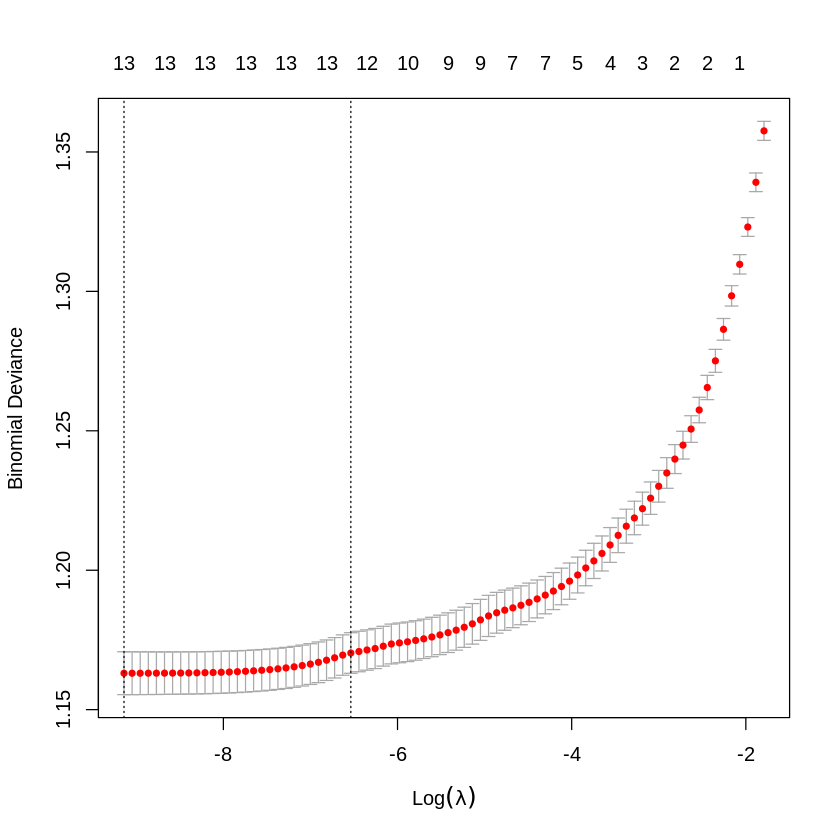

In [4]:
# Exclude total_students (highly correlated with other size-related vars)
df_lasso <- df_subset |> select(-total_students)
df_lasso$high_absenteeism <- df$high_absenteeism

# Create model matrix for Lasso
x <- model.matrix(high_absenteeism ~ ., data = df_lasso)
y <- df$high_absenteeism

# Run Lasso with cross-validation
cvfit <- cv.glmnet(x, y, family = "binomial", alpha = 1)

# Plot cross-validation error against lambda values
plot(cvfit)

# Show selected coefficients at optimal lambda
coef(cvfit, s = "lambda.min")

### Best Subset Selection
We now apply Forward Stepwise Selection to compare models of different sizes and select one based on multiple criteria: Adjusted R², Mallows" Cp, and BIC.

As variables were incrementally added, key demographic and socioeconomic indicators, such as total students, American Indian and Black student counts, and economically disadvantaged male students, were consistently selected. This highlights the importance of specific student populations and economic vulnerability in understanding absenteeism trends. The output matters because it helps isolate the most impactful predictors from a large set of potential features, guiding focused policy responses and more efficient resource allocation in addressing chronic absenteeism in schools.

In [5]:
# Add back total_students since FSS is not sensitive to multicollinearity
df_subset$high_absenteeism <- df$high_absenteeism

# Perform forward stepwise selection
reg_fit_fss <- regsubsets(
  high_absenteeism ~ .,
  data = df_subset,
  method = "forward",
  nvmax = ncol(df_subset)
)

# Extract summary of results
fss_summary <- summary(reg_fit_fss)
print(fss_summary)

Subset selection object
Call: regsubsets.formula(high_absenteeism ~ ., data = df_subset, method = "forward", 
    nvmax = ncol(df_subset))
15 Variables  (and intercept)
                                     Forced in Forced out
total_students                           FALSE      FALSE
american_indian_alaska_native_pct        FALSE      FALSE
asian_pacific_islander_pct               FALSE      FALSE
hispanic_pct                             FALSE      FALSE
black_african_american_pct               FALSE      FALSE
white_pct                                FALSE      FALSE
native_hawaiian_pacific_islander_pct     FALSE      FALSE
student_poverty_ratio                    FALSE      FALSE
total_federal_revenue                    FALSE      FALSE
total_state_revenue                      FALSE      FALSE
total_local_revenue                      FALSE      FALSE
total_expenditures                       FALSE      FALSE
total_salaries                           FALSE      FALSE
total_employee_bene

### Visualization of Model Selection Metrics

We can see how each of the statistics differ with respect to which variables should be included in the best subset. The red point represent the point where the criterion in the best.

[1] "SUBSET WITH MAXIMUM R^2 =" "13"                       
[1] "SUBSET WITH MINIMUM C_p =" "11"                       
[1] "SUBSET WITH MINIMUM BIC =" "8"                        


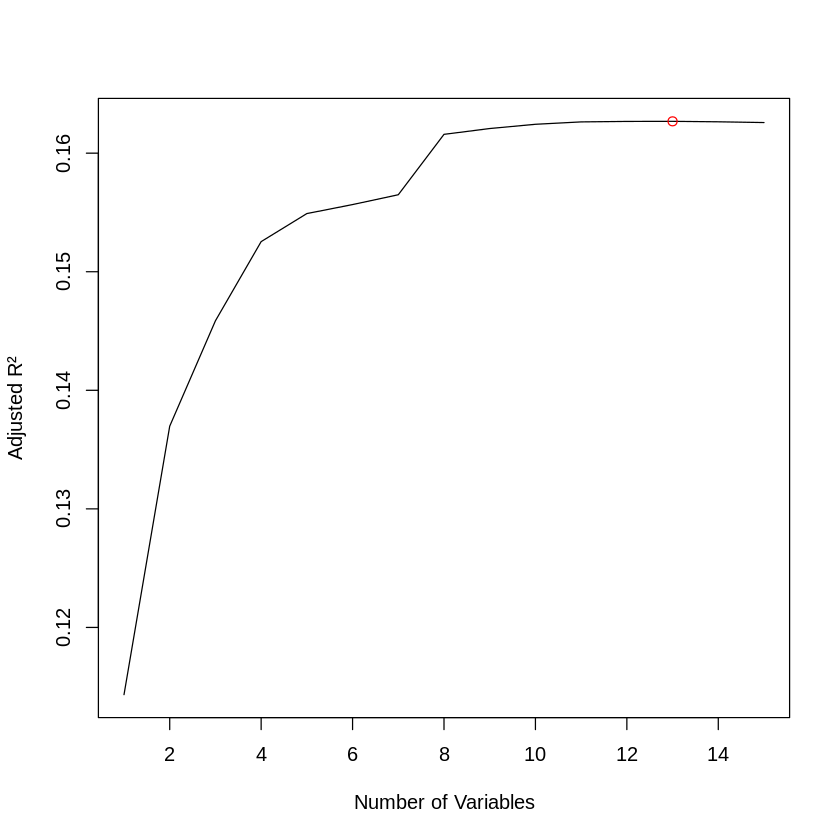

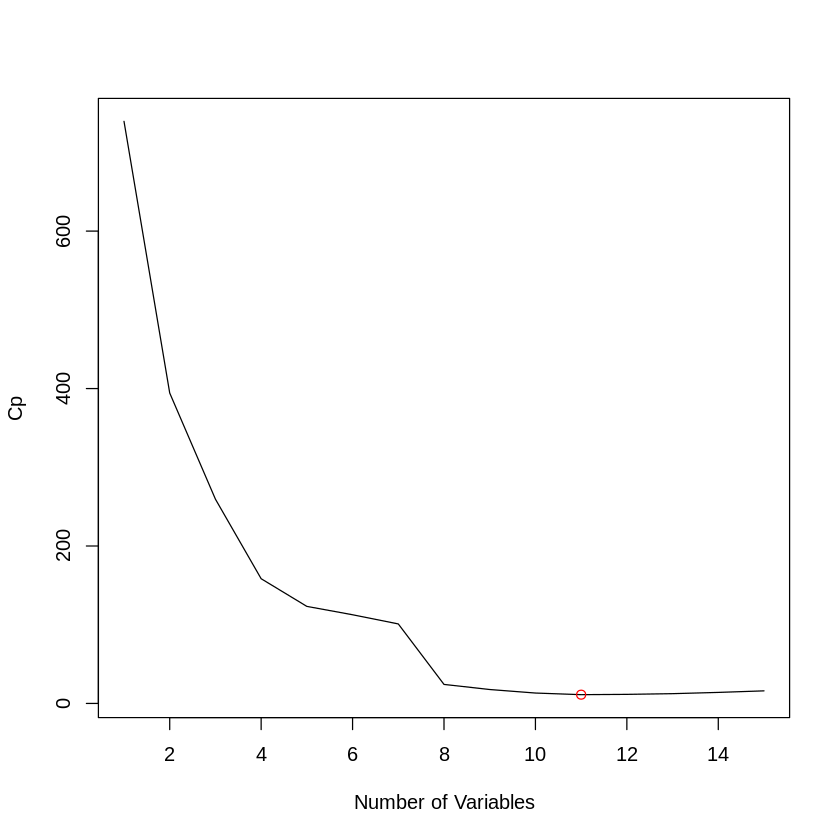

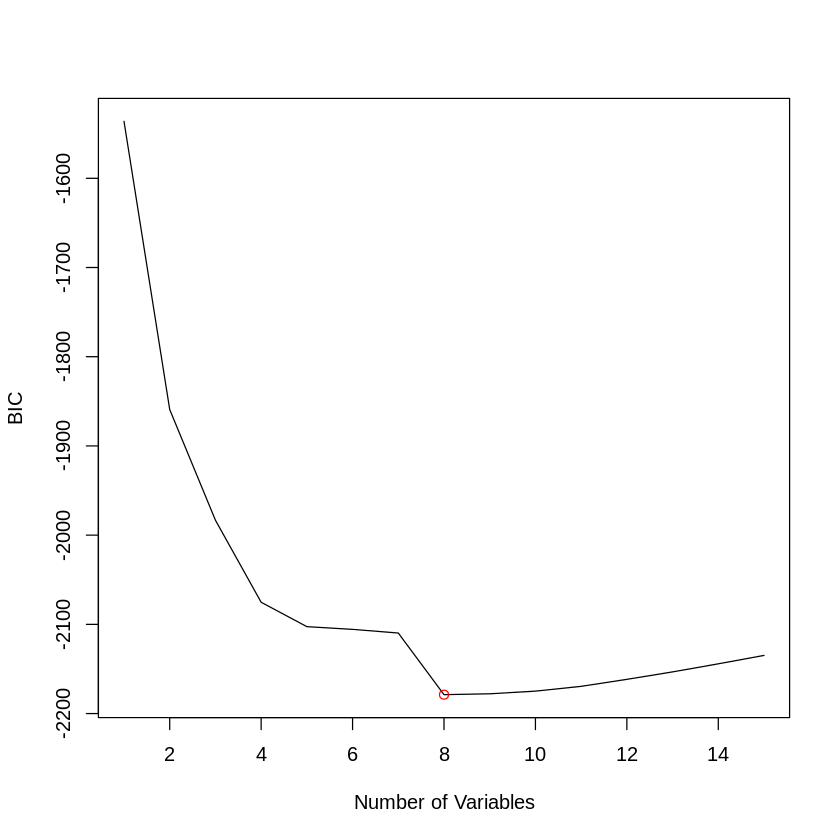

In [6]:
# Find best models by different criteria
r2_best <- which.max(fss_summary$adjr2)
cp_best <- which.min(fss_summary$cp)
bic_best <- which.min(fss_summary$bic)

# Print best subset size for each metric
print(c("SUBSET WITH MAXIMUM R^2 =", r2_best))
print(c("SUBSET WITH MINIMUM C_p =", cp_best))
print(c("SUBSET WITH MINIMUM BIC =", bic_best))

# Adjusted R² plot
plot(fss_summary$adjr2, xlab = "Number of Variables",
     ylab = "Adjusted R²", type = "l")
points(r2_best, fss_summary$adjr2[r2_best], col = "red")

# Cp plot
plot(fss_summary$cp, xlab = "Number of Variables", ylab = "Cp", type = "l")
points(cp_best, fss_summary$cp[cp_best], col = "red")

# BIC plot
plot(fss_summary$bic, xlab = "Number of Variables", ylab = "BIC", type = "l")
points(bic_best, fss_summary$bic[bic_best], col = "red")

### Build Final Dataset with Selected Features
We extract the predictors from the model with the best Adjusted R² and use them to build our final modeling dataset.

In [7]:
# Extract coefficients from the best model (Adj R² criterion)
coef_best <- coef(reg_fit_fss, r2_best)
print(coef_best)

# Extract variable names (excluding intercept)
vars_best <- setdiff(names(coef_best), "(Intercept)")

# Subset original dataset with selected features
df_model_final_bss <- df[, vars_best]

# Add target variables
df_model_final_bss$high_absenteeism <- df$high_absenteeism
df_model_final_bss$high_absenteeism_doe <- df$high_absenteeism_doe
df_model_final_bss$absenteeism_class <- df$absenteeism_class

# Move target variables to the front
df_model_final_bss <- df_model_final_bss[, c(target_cols, setdiff(names(df_model_final_bss), target_cols))] # nolint: line_length_linter.

# Save final dataset for modeling
write.csv(df_model_final_bss, "../data/clean/absenteeism_model_final_bss.csv", row.names = FALSE) # nolint: line_length_linter.

                      (Intercept) american_indian_alaska_native_pct 
                     1.323394e+00                     -1.013110e+00 
       asian_pacific_islander_pct                      hispanic_pct 
                    -1.843226e+00                     -1.021649e+00 
       black_african_american_pct                         white_pct 
                    -1.027597e+00                     -1.294351e+00 
            student_poverty_ratio             total_federal_revenue 
                     1.401008e+00                      1.376713e-09 
              total_state_revenue               total_local_revenue 
                     3.133483e-10                     -5.557655e-10 
               total_expenditures                    total_salaries 
                    -2.314509e-10                      5.682928e-10 
          total_employee_benefits          expenditures_per_student 
                     1.082171e-09                      2.133765e-06 
